In [224]:
%run constants.ipynb
%run dataloaders.ipynb
%run utils.ipynb
%run prior.ipynb
%run models.ipynb
%run coresets.ipynb

In [264]:
class ExperimentConfig:
    def __init__(self, 
                 dataset_type='split',
                 task_type='classification',
                 prior_type='gaussian',
                 init_prior_mu=0.0,
                 init_prior_scale=0.1,
                 init_const=-6.0,
                 coreset_alg_name="random",
                 coreset_size=200
                ):
        # Model hyperparameters
        self.prior_type = prior_type  # 'gaussian' or 'exponential'
        self.task_type = task_type
        self.dataset_type = dataset_type
        self.init_prior_mu = init_prior_mu
        self.init_prior_scale = init_prior_scale
        self.init_const = init_const
        self.input_dim = 784
        self.hidden_dim = 256
        self.num_samples = 10
        
        # Training parameters
        self.num_epochs = 100
        self.batch_size = 256
        self.learning_rate = 0.001
        self.coreset_alg_name = coreset_alg_name
        self.coreset_size = coreset_size
        self.patience = 5
        self.early_stop_threshold = 1e-4
        
        
    def validate(self):
        assert self.prior_type in ['gaussian', 'exponential']
        assert self.dataset_type in ['split', 'permuted']
        assert len(self.tasks) > 0

    @property
    def coreset_alg(self):
        """Get coreset algorithm as a function based on the config"""
        if self.coreset_alg_name == "kcenter":
            return KCenterCoresetAlg(self.coreset_size)
        elif self.coreset_alg_name == "random":
            return RandomCoresetAlg(self.coreset_size)
        else:
            return None

    @property
    def tasks(self):
        return range(NUM_MNIST_CLASSES) if self.dataset_type == 'permuted' else \
                [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]

    @property
    def dataloaders(self):
        dataloaders = PermutedDataLoader(self.tasks, batch_size=self.batch_size) if self.dataset_type == 'permuted' else \
                        SplitDataLoader(self.tasks, batch_size=self.batch_size)
        return dataloaders.run()

    @property
    def output_dims(self):
        # Multihead NN for SplitMNIST
        if self.dataset_type == 'split' and self.task_type == 'classification':
            return [len(t) for t in self.tasks]
        elif self.dataset_type == 'split' and self.task_type == 'regression':
            return [NUM_MNIST_CLASSES for _ in self.tasks]  # one-hot-encoding of classes will have size NUM_MNIST_CLASSES
        else:
            return [NUM_MNIST_CLASSES] # single head for PermutedMNIST

    @property
    def output_dim(self):
        return self.output_dims[0]

    @property
    def eval_metric(self):
        return 'Accuracy' if self.task_type == 'classification' else 'RMSE'

    @property
    def prior(self):
        return ExponentialPrior() if self.prior_type == 'exponential' else GaussianPrior()

    def prepare_targets(self, targets, task):
        if self.dataset_type == 'split' and self.task_type == 'classification':
            # reindex targets - always treat binary class labels as 0/1
            targets -= task[0] 
        elif self.task_type == 'regression':
            # one hot encoding of class labels
            targets = F.one_hot(targets, num_classes=self.output_dim).float()  # [batch_size, 10]
        return targets

    def loss_fn(self, outputs, targets, task_id):
        # targets are not yet processed
        # print('loss_fn outputs:', outputs)
        # print('loss_fn targets:', targets)  # should still contain original class labels
        task = self.tasks[task_id]
        final_targets = self.prepare_targets(targets, task)
        if self.task_type == 'regression': # Gaussian likelihood - MSE loss
            loss = F.mse_loss(outputs.mean(-1), final_targets)
        else: # Categorical likelihood - negative log likelihood loss
            # print('loss_fn final targets:', final_targets)  # should still contain original class labels
            log_output = torch.logsumexp(outputs, dim=-1) - np.log(self.num_samples)
            loss = F.nll_loss(log_output, final_targets)
        return loss

In [241]:
def train(model, dataloader, task_id):
    """Train model on a specific task"""
    config = model.config
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    model.train()
    
    prev_loss = float('inf')
    num_consec_worse_epochs = 0
    task_id = model.task_id(task_id)
    
    for epoch in range(config.num_epochs):
        epoch_loss = 0.0
        
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            optimizer.zero_grad()
            # Monte Carlo sampling
            outputs = torch.zeros(inputs.size(0), config.output_dim,   # len(task)
                                  config.num_samples, device=DEVICE)
            for i in range(config.num_samples):
                net_out = model(inputs, task_id)
                outputs[..., i] = (net_out if config.task_type == 'regression' else F.log_softmax(net_out, dim=-1))

            loss = model.compute_loss(outputs, targets, task_id)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Early stopping
        if epoch_loss + config.early_stop_threshold > prev_loss:
            prev_loss = epoch_loss
            num_consec_worse_epochs = 0
        else:
            num_consec_worse_epochs += 1
            if num_consec_worse_epochs >= config.patience:
                break

In [242]:
def test(model, dataloader, task_id, ret_std=False):
    """Test model supporting both classification and regression"""
    model.eval()
    metrics = []
    config = model.config  # for brevity
    task_id = model.task_id(task_id)
    task = config.tasks[task_id]
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            # Prepare targets based on task type
            targets = config.prepare_targets(targets, task)

            outputs = torch.zeros(inputs.size(0), config.output_dim,
                                config.num_samples, device=DEVICE)
            for i in range(config.num_samples):
                net_out = model(inputs, task_id)
                outputs[..., i] = (net_out if config.task_type == 'regression' else F.log_softmax(net_out, dim=-1))
            
            # Calculate metric based on task type
            if config.task_type == 'regression':
                pred = outputs.mean(-1)
                rmse = torch.sqrt(F.mse_loss(pred, targets))
                metrics.append(rmse.item())
            else:
                log_output = torch.logsumexp(outputs, dim=-1) - np.log(config.num_samples)
                acc = (log_output.argmax(-1) == targets).float().mean()
                metrics.append(acc.item())
    
    return np.mean(metrics) if not ret_std else (np.mean(metrics), np.std(metrics))

In [243]:
def run_experiment_for(model):
    config = model.config
    dataloaders = config.dataloaders
    coreset_alg = config.coreset_alg
    assert coreset_alg.coresets == []  # should initially be empty
    results = np.zeros((len(config.tasks), len(config.tasks)))
    results_std = np.zeros((len(config.tasks), len(config.tasks)))
    is_vcl = isinstance(model, VCLNN)
    
    # Train and evaluate
    for task_id in range(len(config.tasks)):
        print(f"\nTraining on Task {task_id+1} ...")
        train_loader, _ = dataloaders[task_id]
        # Train on non-coreset data
        train(model, train_loader, task_id)
        print(f"... Finished training on Task {task_id+1}")
        
        # Train on new coreset
        if is_vcl and coreset_alg is not None and config.coreset_size > 0:  # VCL models with coresets
            coreset_alg.add_coreset(train_loader)
            # Train on coresets from previous tasks
            for prev_task in range(task_id+1):
                print(f"\nRe-training on Task {prev_task+1} ...")
                train(model, coreset_alg.coresets[prev_task], prev_task)
        print()
        
        # Evaluate on previous tasks
        for curr_t in range(task_id+1):
            _, test_loader = dataloaders[curr_t]
            score, std = test(model, test_loader, curr_t, ret_std=True)
            print(f"Task {(curr_t+1):2d}  {config.eval_metric}: {np.round(score, 4):0.4f} ± {np.round(std, 4):0.4f}")
            results[task_id, curr_t] = score
            results_std[task_id, curr_t] = std
        print()

        if is_vcl:  # update prior for VCL models
            model.update_priors()
            
    return results, results_std

In [244]:
from copy import deepcopy

In [246]:
def run_experiment(config, ret_std=False):
    """Run complete VCL experiment"""
    exponential_config = deepcopy(config)
    exponential_config.prior_type = 'exponential'
    # exponential_config.init_prior_scale = 0.01
    
    # Initialize models
    vanillaNN = VanillaNN(config).to(DEVICE)
    gaussian_vclNN = VCLNN(config).to(DEVICE)
    exponential_vclNN = VCLNN(exponential_config).to(DEVICE)

    vanilla_results, vanilla_results_std = run_experiment_for(vanillaNN)
    gaussian_vcl_results, gaussian_vcl_results_std = run_experiment_for(gaussian_vclNN)
    exponential_vcl_results, exponential_vcl_results_std = run_experiment_for(exponential_vclNN)
    
    results = { 'vanilla': vanilla_results, 'gaussian_vcl': gaussian_vcl_results, 'exponential_vcl': exponential_vcl_results }
    results_std = { 'vanilla': vanilla_results_std, 'gaussian_vcl': gaussian_vcl_results_std, 'exponential_vcl': exponential_vcl_results_std }
    
    return results if not ret_std else (results, results_std)

In [247]:
def plot_results(config, results, results_std=None, export=True):
    """Plot comparison of results with optional error bars."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    x_ticks = range(1, len(config.tasks)+1)
    
    for model in results:
        mean_yval = (lambda res: np.mean(res[model], axis=0, where=(res[model] > 1e-6))) # average over non-zero metrics
        mean_scores = mean_yval(results)
        x_vals = np.arange(len(mean_scores)) + 1
        # If std info is provided, add error bars
        if results_std is not None:
            ax1.errorbar(x_vals, mean_scores, yerr=mean_yval(results_std), 
                         label=model, marker='o', markersize=5, capsize=4)
        else:
            ax1.plot(x_vals, mean_scores, label=model, marker='o', markersize=5)
    
    ax1.set_xticks(x_ticks)
    ax1.set_title(f"Mean {config.eval_metric}", fontsize=18)
    ax1.set_xlabel("# Tasks", fontsize=15)
    ax1.legend(fontsize=16)

    # Final score plot (no std)
    for model in results:
        final_scores = results[model][-1]
        x_vals = np.arange(len(final_scores)) + 1
        if results_std is not None:
            ax2.errorbar(x_vals, final_scores, yerr=results_std[model][-1], label=model,
                         marker='o', markersize=5, capsize=4)
        else:
            ax2.plot(x_vals, final_scores, label=model, marker='o', markersize=5)

    ax2.set_xticks(x_ticks)
    ax2.set_title(f"Final {config.eval_metric}", fontsize=18)
    ax2.set_xlabel("# Tasks", fontsize=15)
    ax2.legend(fontsize=16)

    plt.tight_layout()
    if export:
        plt.savefig(plot_filepath(config))
    
    plt.show()

# Minimum required extensions

In [186]:
config = ExperimentConfig()
config.dataset_type = 'split'
config.task_type = 'classification'
config.coreset_alg_name = 'random'

# Set random seeds
torch.manual_seed(888)
np.random.seed(777)

# Run experiment
split_cla_results, split_cla_results_std = run_experiment(config, ret_std=True)


Training on Task 1 ...
loss_fn targets: tensor([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0])
loss_fn final targets: tensor([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,

KeyboardInterrupt: 

In [82]:
split_cla_results

{'vanilla': array([[0.99913194, 0.        , 0.        , 0.        , 0.        ],
        [0.99782986, 0.99608203, 0.        , 0.        , 0.        ],
        [0.81351057, 0.84039844, 0.99804688, 0.        , 0.        ],
        [0.71039983, 0.91922265, 0.97870617, 0.99886739, 0.        ],
        [0.86007463, 0.95099609, 0.98486328, 0.99398458, 0.99120072]]),
 'gaussian_vcl': array([[0.99956597, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.90107422, 0.        , 0.        , 0.        ],
        [1.        , 0.95058984, 0.96997666, 0.        , 0.        ],
        [0.99956597, 0.95101953, 0.9725967 , 0.9626188 , 0.        ],
        [0.99956597, 0.94851953, 0.98388672, 0.95693561, 0.96107299]]),
 'exponential_vcl': array([[1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.99826389, 0.98921094, 0.        , 0.        , 0.        ],
        [1.        , 0.96475   , 0.99462891, 0.        , 0.        ],
        [0.99782986, 0.98485156, 0.99072

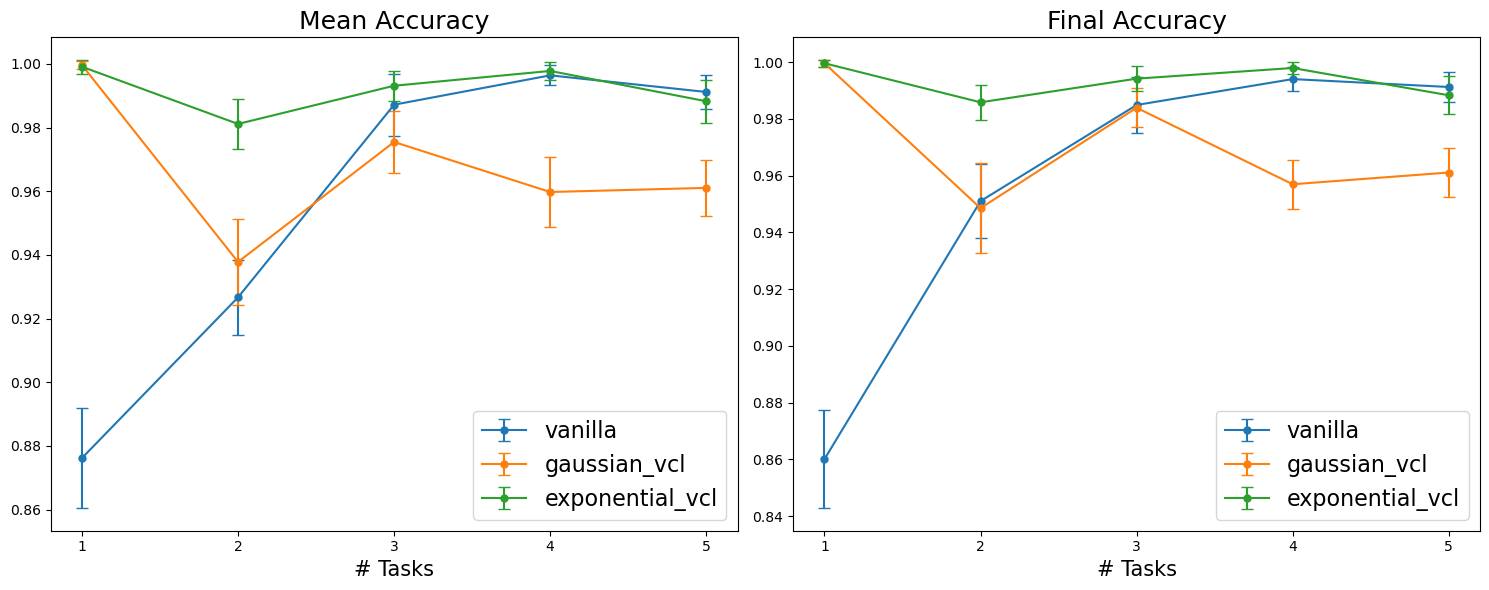

In [83]:
plot_results(config, split_cla_results, results_std=split_cla_results_std)

In [170]:
config = ExperimentConfig()
config.dataset_type = 'split'
config.task_type = 'regression'
config.coreset_alg_name = 'random'
config.init_prior_scale = 0.01
config.validate()

torch.manual_seed(777)
np.random.seed(888)

# Run experiment
split_reg_results, split_reg_results_std = run_experiment(config, ret_std=True)


Training on Task 1 ...
... Finished training on Task 1

Task  1  RMSE: 0.0175 ± 0.0033


Training on Task 2 ...
... Finished training on Task 2

Task  1  RMSE: 0.1405 ± 0.0050
Task  2  RMSE: 0.0351 ± 0.0051


Training on Task 3 ...
... Finished training on Task 3

Task  1  RMSE: 0.1938 ± 0.0041
Task  2  RMSE: 0.1421 ± 0.0063
Task  3  RMSE: 0.0227 ± 0.0037


Training on Task 4 ...
... Finished training on Task 4

Task  1  RMSE: 0.2154 ± 0.0065
Task  2  RMSE: 0.2463 ± 0.0083
Task  3  RMSE: 0.1571 ± 0.0034
Task  4  RMSE: 0.0212 ± 0.0048


Training on Task 5 ...
... Finished training on Task 5

Task  1  RMSE: 0.2107 ± 0.0033
Task  2  RMSE: 0.2640 ± 0.0081
Task  3  RMSE: 0.2288 ± 0.0034
Task  4  RMSE: 0.1362 ± 0.0047
Task  5  RMSE: 0.0393 ± 0.0059


Training on Task 1 ...
... Finished training on Task 1

Re-training on Task 1 ...

Task  1  RMSE: 0.0837 ± 0.0026


Training on Task 2 ...
... Finished training on Task 2

Re-training on Task 1 ...

Re-training on Task 2 ...

Task  1  RMSE: 0.1

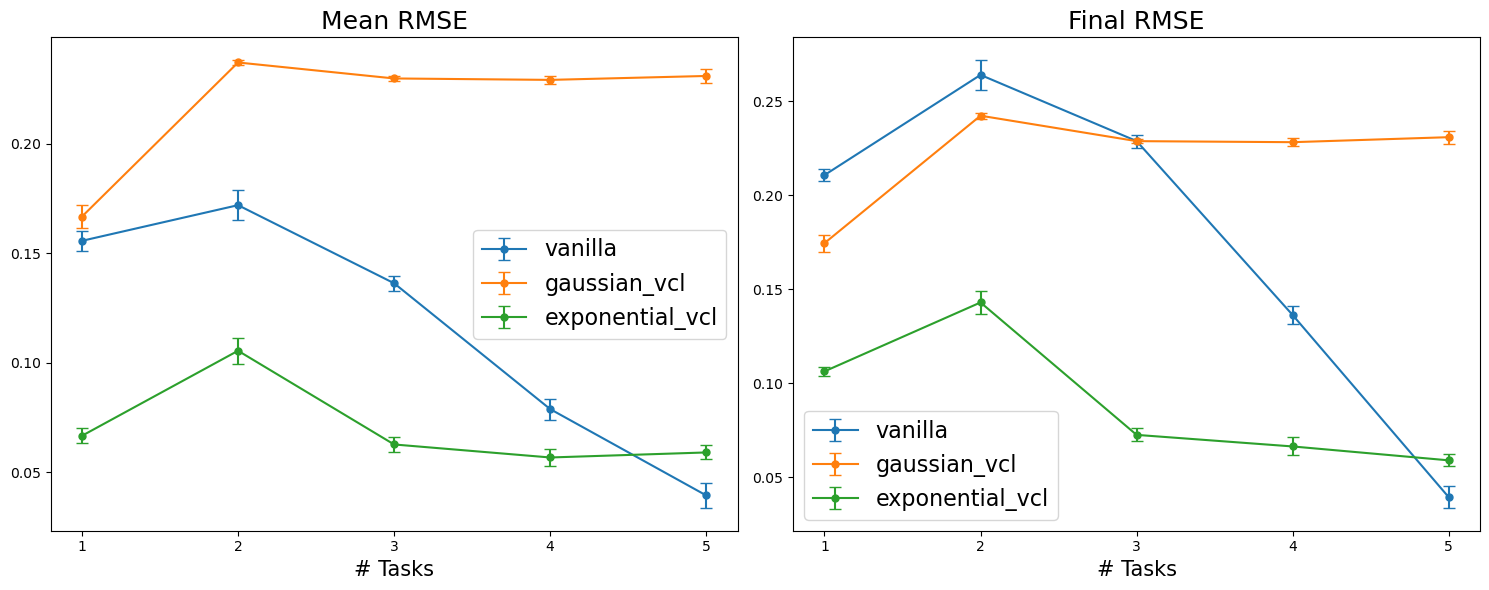

In [172]:
plot_results(config, split_reg_results, split_reg_results_std)

In [173]:
config = ExperimentConfig()
config.task_type = 'regression'
config.coreset_alg_name = 'random'
config.init_prior_scale = 0.001
config.validate()

torch.manual_seed(777)
np.random.seed(888)

# Run experiment
split_reg_results3, split_reg_results_std3 = run_experiment(config, ret_std=True)


Training on Task 1 ...
... Finished training on Task 1

Task  1  RMSE: 0.0175 ± 0.0033


Training on Task 2 ...
... Finished training on Task 2

Task  1  RMSE: 0.1405 ± 0.0050
Task  2  RMSE: 0.0351 ± 0.0051


Training on Task 3 ...
... Finished training on Task 3

Task  1  RMSE: 0.1938 ± 0.0041
Task  2  RMSE: 0.1421 ± 0.0063
Task  3  RMSE: 0.0227 ± 0.0037


Training on Task 4 ...
... Finished training on Task 4

Task  1  RMSE: 0.2154 ± 0.0065
Task  2  RMSE: 0.2463 ± 0.0083
Task  3  RMSE: 0.1571 ± 0.0034
Task  4  RMSE: 0.0212 ± 0.0048


Training on Task 5 ...
... Finished training on Task 5

Task  1  RMSE: 0.2107 ± 0.0033
Task  2  RMSE: 0.2640 ± 0.0081
Task  3  RMSE: 0.2288 ± 0.0034
Task  4  RMSE: 0.1362 ± 0.0047
Task  5  RMSE: 0.0393 ± 0.0059


Training on Task 1 ...
... Finished training on Task 1

Re-training on Task 1 ...

Task  1  RMSE: 0.3005 ± 0.0002


Training on Task 2 ...
... Finished training on Task 2

Re-training on Task 1 ...

Re-training on Task 2 ...

Task  1  RMSE: 0.2

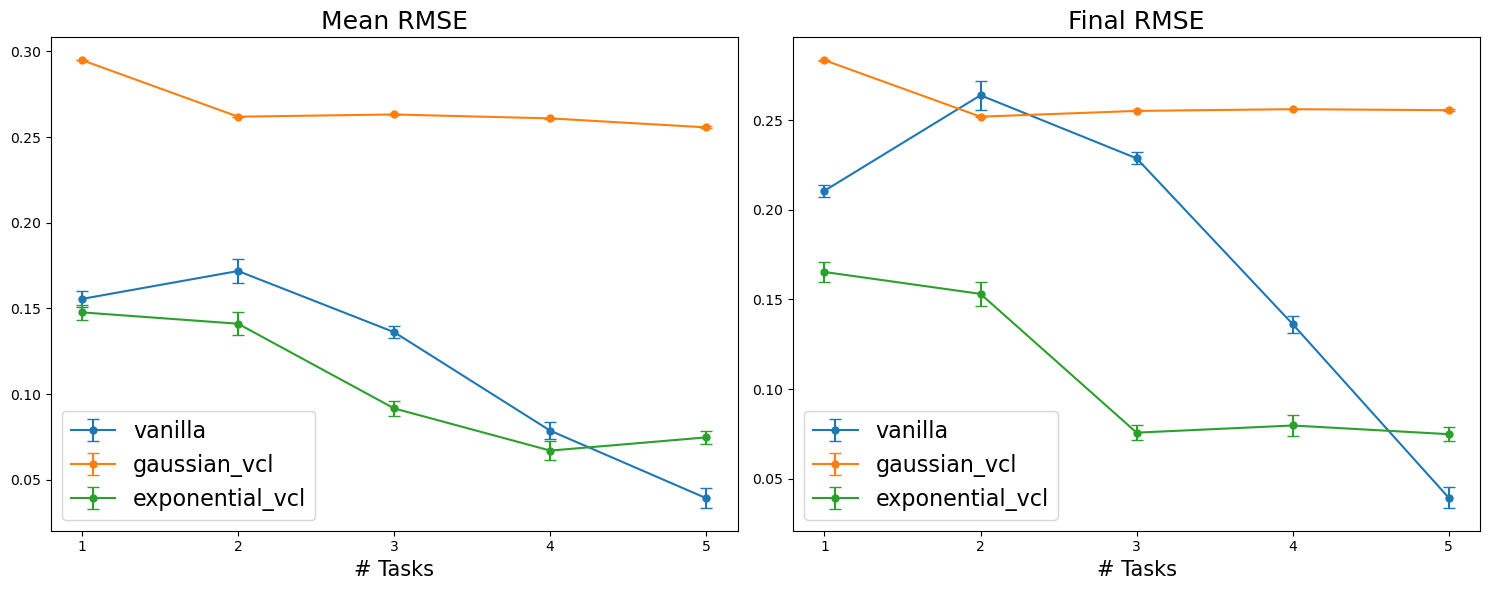

In [174]:
plot_results(config, split_reg_results3, split_reg_results_std3)

# Changing Coreset Size

In [92]:
config = ExperimentConfig()
config.dataset_type = 'split'
config.task_type = 'classification'
config.coreset_size = 100
config.validate()

torch.manual_seed(777)
np.random.seed(888)

# Run experiment
split_cla_results_100, split_cla_results_std_100 = run_experiment(config, ret_std=True)


Training on Task 1 ...
... Finished training on Task 1

Task  1  Accuracy: 0.9996 ± 0.0012


Training on Task 2 ...
... Finished training on Task 2

Task  1  Accuracy: 0.9978 ± 0.0027
Task  2  Accuracy: 0.9961 ± 0.0062


Training on Task 3 ...
... Finished training on Task 3

Task  1  Accuracy: 0.8172 ± 0.0239
Task  2  Accuracy: 0.9721 ± 0.0060
Task  3  Accuracy: 0.9980 ± 0.0028


Training on Task 4 ...
... Finished training on Task 4

Task  1  Accuracy: 0.6692 ± 0.0202
Task  2  Accuracy: 0.9496 ± 0.0127
Task  3  Accuracy: 0.9720 ± 0.0086
Task  4  Accuracy: 0.9990 ± 0.0017


Training on Task 5 ...
... Finished training on Task 5

Task  1  Accuracy: 0.8852 ± 0.0248
Task  2  Accuracy: 0.9701 ± 0.0073
Task  3  Accuracy: 0.9843 ± 0.0055
Task  4  Accuracy: 0.9839 ± 0.0053
Task  5  Accuracy: 0.9873 ± 0.0112


Training on Task 1 ...
... Finished training on Task 1

Re-training on Task 1 ...

Task  1  Accuracy: 0.9996 ± 0.0012


Training on Task 2 ...
... Finished training on Task 2

Re-train

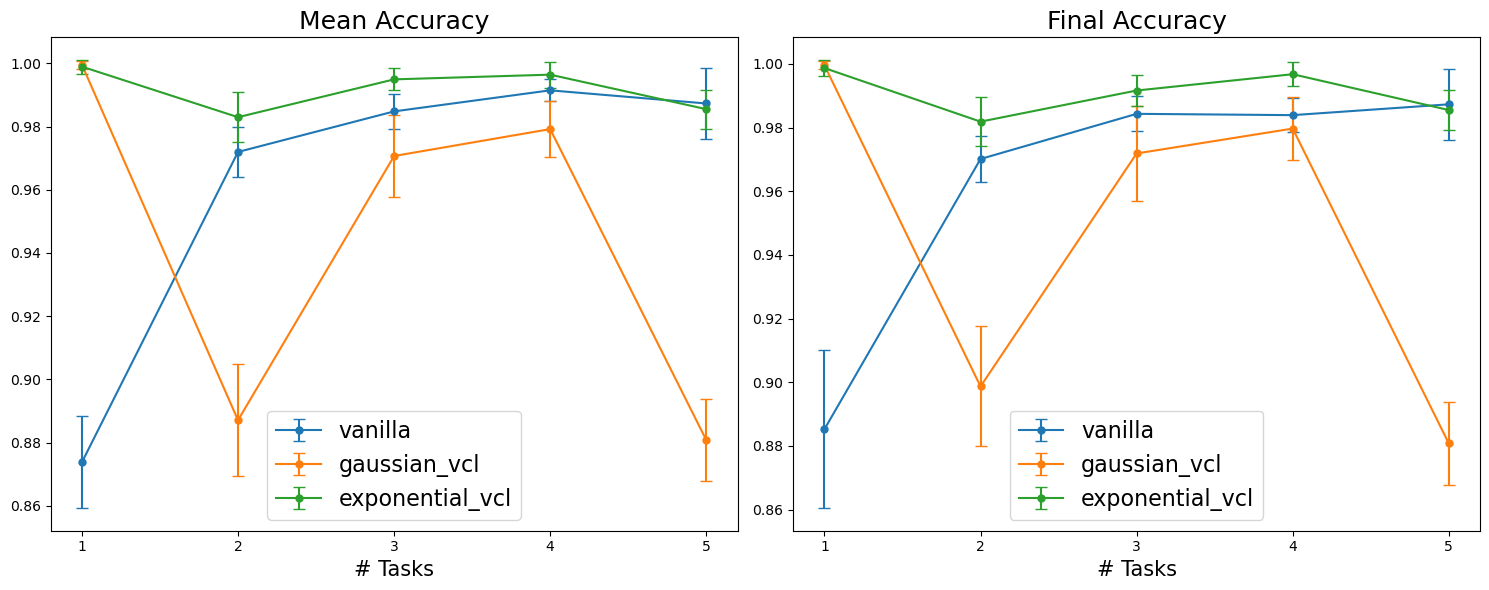

In [93]:
plot_results(config, split_cla_results_100, results_std=split_cla_results_std_100)

In [175]:
config = ExperimentConfig()
config.dataset_type = 'split'
config.task_type = 'regression'
config.coreset_size = 100
config.validate()

torch.manual_seed(777)
np.random.seed(888)

# Run experiment
split_reg_results_100, split_reg_results_std_100 = run_experiment(config, ret_std=True)


Training on Task 1 ...
... Finished training on Task 1

Task  1  RMSE: 0.0175 ± 0.0033


Training on Task 2 ...
... Finished training on Task 2

Task  1  RMSE: 0.1405 ± 0.0050
Task  2  RMSE: 0.0351 ± 0.0051


Training on Task 3 ...
... Finished training on Task 3

Task  1  RMSE: 0.1938 ± 0.0041
Task  2  RMSE: 0.1421 ± 0.0063
Task  3  RMSE: 0.0227 ± 0.0037


Training on Task 4 ...
... Finished training on Task 4

Task  1  RMSE: 0.2154 ± 0.0065
Task  2  RMSE: 0.2463 ± 0.0083
Task  3  RMSE: 0.1571 ± 0.0034
Task  4  RMSE: 0.0212 ± 0.0048


Training on Task 5 ...
... Finished training on Task 5

Task  1  RMSE: 0.2107 ± 0.0033
Task  2  RMSE: 0.2640 ± 0.0081
Task  3  RMSE: 0.2288 ± 0.0034
Task  4  RMSE: 0.1362 ± 0.0047
Task  5  RMSE: 0.0393 ± 0.0059


Training on Task 1 ...
... Finished training on Task 1

Re-training on Task 1 ...

Task  1  RMSE: 0.0751 ± 0.0009


Training on Task 2 ...
... Finished training on Task 2

Re-training on Task 1 ...

Re-training on Task 2 ...

Task  1  RMSE: 0.1

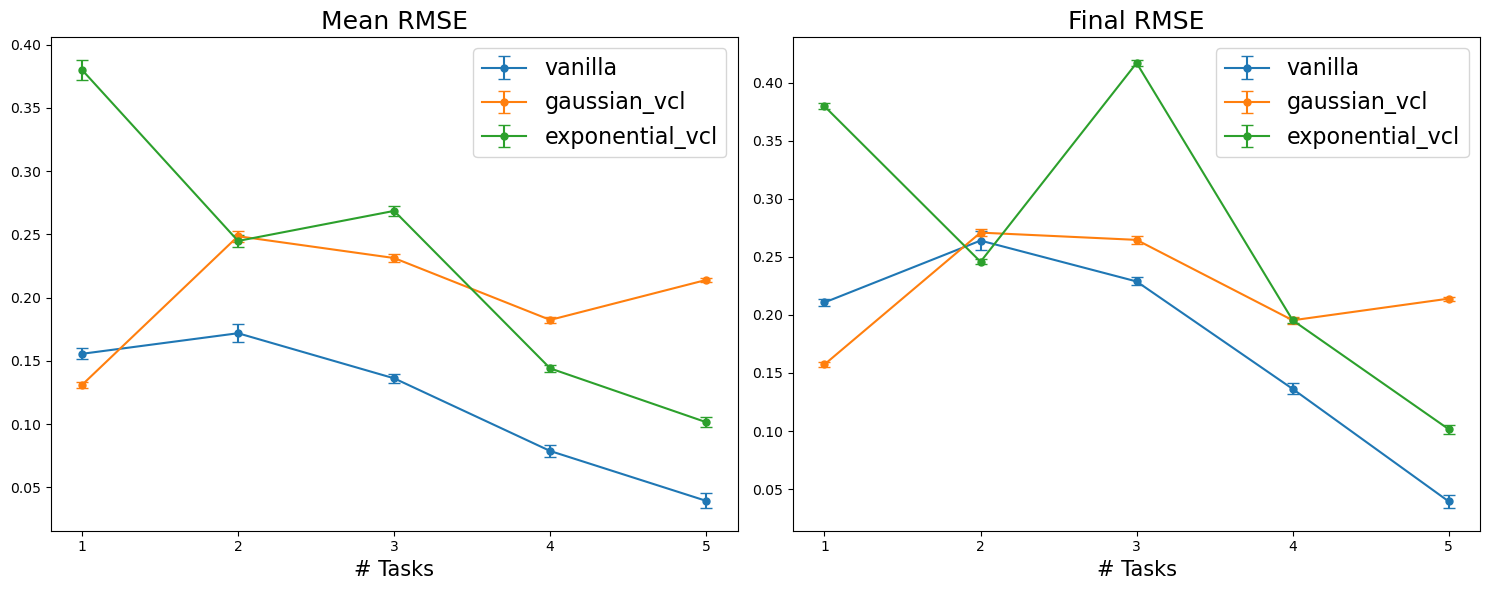

In [176]:
plot_results(config, split_reg_results_100, results_std=split_reg_results_std_100)

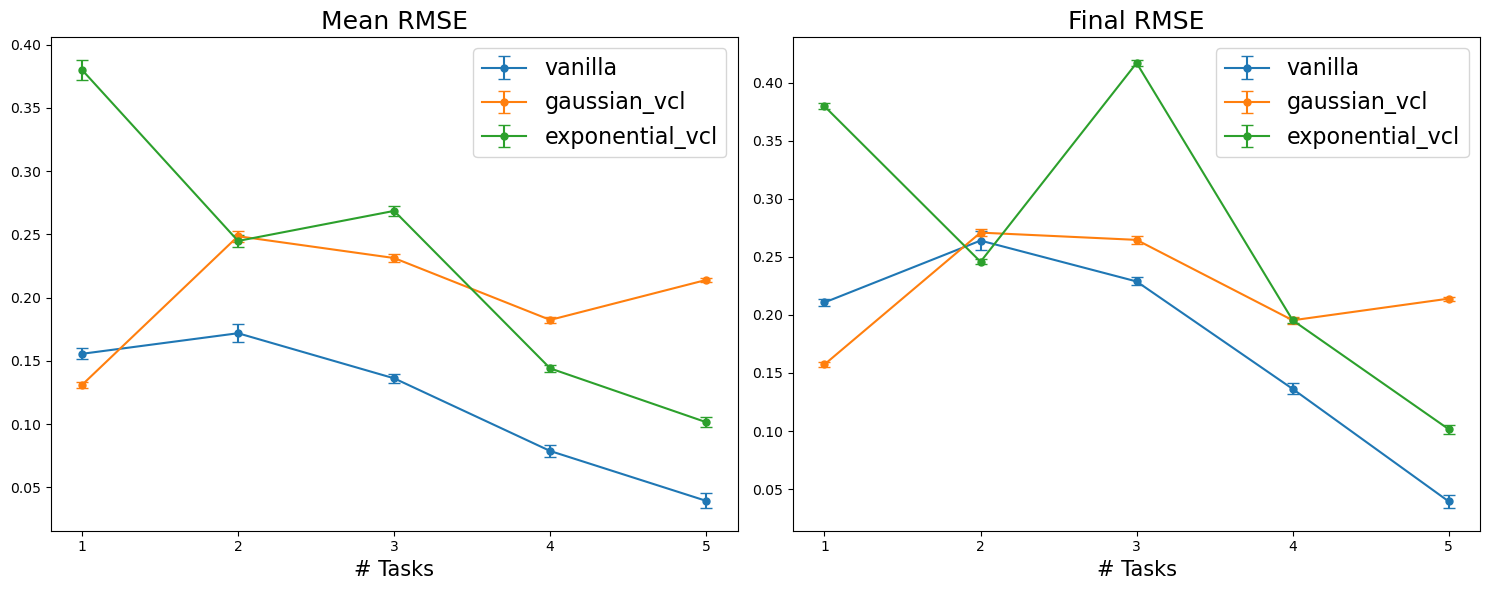

In [95]:
plot_results(config, split_reg_results_0, results_std=split_reg_results_std_0)

# Changing Coreset Algorithm

In [248]:
config = ExperimentConfig()
config.task_type = 'classification'
config.coreset_alg_name = 'kcenter'
config.validate()

# Run experiment
split_cla_results_kcenter, split_cla_results_kcenter_std = run_experiment(config, ret_std=True)


Training on Task 1 ...
... Finished training on Task 1

Task  1  Accuracy: 0.9996 ± 0.0012


Training on Task 2 ...
... Finished training on Task 2

Task  1  Accuracy: 0.9987 ± 0.0026
Task  2  Accuracy: 0.9941 ± 0.0060


Training on Task 3 ...
... Finished training on Task 3

Task  1  Accuracy: 0.9391 ± 0.0137
Task  2  Accuracy: 0.9457 ± 0.0174
Task  3  Accuracy: 0.9980 ± 0.0034


Training on Task 4 ...
... Finished training on Task 4

Task  1  Accuracy: 0.9033 ± 0.0109
Task  2  Accuracy: 0.9261 ± 0.0159
Task  3  Accuracy: 0.9975 ± 0.0040
Task  4  Accuracy: 0.9990 ± 0.0017


Training on Task 5 ...
... Finished training on Task 5

Task  1  Accuracy: 0.9451 ± 0.0095
Task  2  Accuracy: 0.9250 ± 0.0161
Task  3  Accuracy: 0.9807 ± 0.0124
Task  4  Accuracy: 0.9940 ± 0.0027
Task  5  Accuracy: 0.9923 ± 0.0026


Training on Task 1 ...
... Finished training on Task 1

Re-training on Task 1 ...

Task  1  Accuracy: 0.9991 ± 0.0016


Training on Task 2 ...
... Finished training on Task 2

Re-train

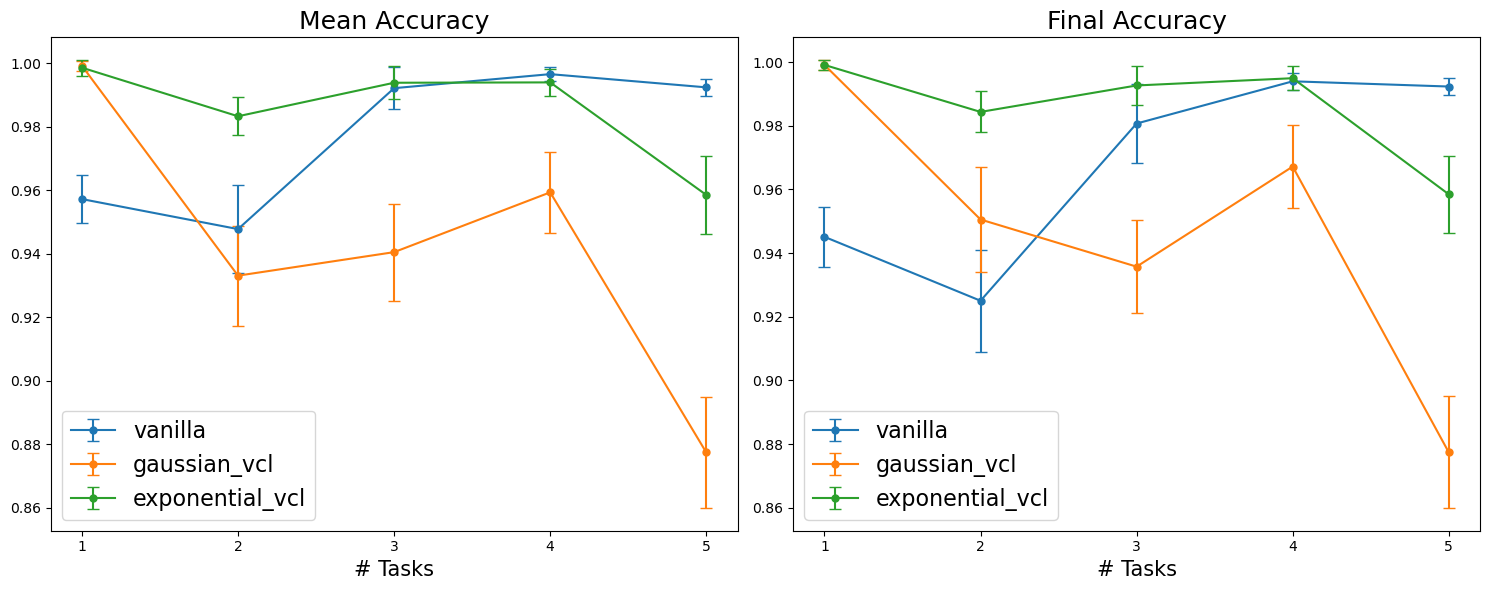

In [249]:
plot_results(config, split_cla_results_kcenter, results_std=split_cla_results_kcenter_std)

In [196]:
config = ExperimentConfig()
config.task_type = 'regression'
config.coreset_alg_name = 'kcenter'
config.validate()

# Run experiment
split_reg_results_kcenter, split_reg_results_kcenter_std = run_experiment(config, ret_std=True)


Training on Task 1 ...
... Finished training on Task 1

Task  1  RMSE: 0.0175 ± 0.0040


Training on Task 2 ...
... Finished training on Task 2

Task  1  RMSE: 0.1252 ± 0.0026
Task  2  RMSE: 0.0334 ± 0.0046


Training on Task 3 ...
... Finished training on Task 3

Task  1  RMSE: 0.2161 ± 0.0045
Task  2  RMSE: 0.1587 ± 0.0020
Task  3  RMSE: 0.0217 ± 0.0025


Training on Task 4 ...
... Finished training on Task 4

Task  1  RMSE: 0.2366 ± 0.0028
Task  2  RMSE: 0.2068 ± 0.0054
Task  3  RMSE: 0.1344 ± 0.0022
Task  4  RMSE: 0.0201 ± 0.0033


Training on Task 5 ...
... Finished training on Task 5

Task  1  RMSE: 0.1955 ± 0.0041
Task  2  RMSE: 0.2595 ± 0.0055
Task  3  RMSE: 0.1787 ± 0.0045
Task  4  RMSE: 0.0957 ± 0.0037
Task  5  RMSE: 0.0339 ± 0.0044


Training on Task 1 ...
... Finished training on Task 1

Re-training on Task 1 ...

Task  1  RMSE: 0.0868 ± 0.0021


Training on Task 2 ...
... Finished training on Task 2

Re-training on Task 1 ...

Re-training on Task 2 ...

Task  1  RMSE: 0.1

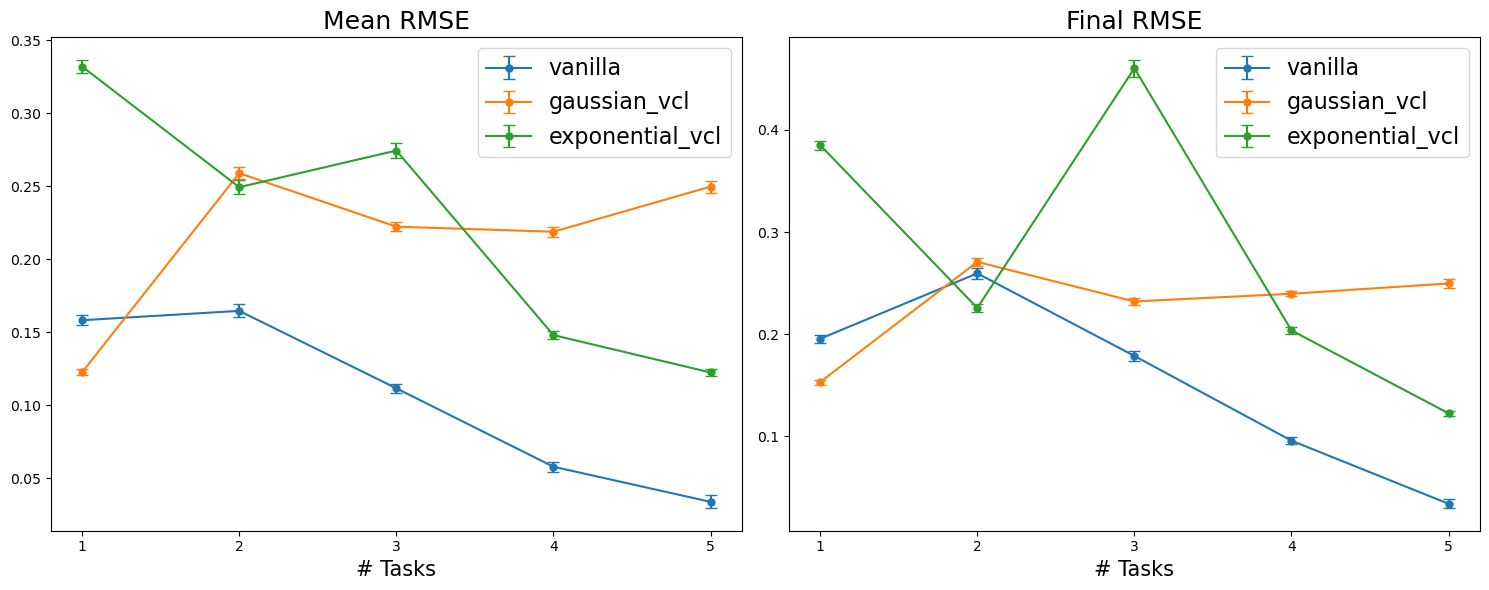

In [197]:
plot_results(config, split_reg_results_kcenter, results_std=split_reg_results_kcenter_std)

# Compare multiple changes

In [265]:
def run_experiment(task_type='classification', init_prior_scale=0.1, coreset_size=200, ret_std=True):
    """Run complete VCL experiment"""
    gaussian_config = ExperimentConfig(task_type=task_type,
                                      init_prior_scale=init_prior_scale,
                                      coreset_size=coreset_size)
    exponential_config = ExperimentConfig(task_type=task_type, 
                                          prior_type = 'exponential',
                                          init_prior_scale=init_prior_scale,
                                          coreset_size=coreset_size)
    gaussian_kcenter_config = ExperimentConfig(task_type=task_type,
                                               coreset_alg_name='kcenter',
                                               init_prior_scale=init_prior_scale,
                                               coreset_size=coreset_size)
    exponential_kcenter_config = ExperimentConfig(task_type=task_type, 
                                                  prior_type = 'exponential',
                                                  coreset_alg_name='kcenter',
                                                  init_prior_scale=init_prior_scale,
                                                  coreset_size=coreset_size)
    
    
    # Initialize models
    vanillaNN = VanillaNN(gaussian_config).to(DEVICE)
    gaussian_random_vclNN = VCLNN(gaussian_config).to(DEVICE)
    exponential_random_vclNN = VCLNN(exponential_config).to(DEVICE)
    gaussian_kcenter_vclNN = VCLNN(gaussian_kcenter_config).to(DEVICE)
    exponential_kcenter_vclNN = VCLNN(exponential_kcenter_config).to(DEVICE)
    

    vanilla_results, vanilla_results_std = run_experiment_for(vanillaNN)
    gaussian_vcl_results, gaussian_vcl_results_std = run_experiment_for(gaussian_random_vclNN)
    exponential_vcl_results, exponential_vcl_results_std = run_experiment_for(exponential_random_vclNN)
    gaussian_kcenter_vcl_results, gaussian_kcenter_vcl_results_std = run_experiment_for(gaussian_kcenter_vclNN)
    exponential_kcenter_vcl_results, exponential_kcenter_vcl_results_std = run_experiment_for(exponential_kcenter_vclNN)
    
    results = { 'Vanilla': vanilla_results, 
               'Gaussian VCL (Random)': gaussian_vcl_results, 'Exponential VCL (Random)': exponential_vcl_results,
               'Gaussian VCL (K-center)': gaussian_kcenter_vcl_results, 'Exponential VCL (K-center)': exponential_kcenter_vcl_results }
    results_std = { 'Vanilla': vanilla_results_std, 
                    'Gaussian VCL (Random)': gaussian_vcl_results_std, 'Exponential VCL (Random)': exponential_vcl_results_std,
                    'Gaussian VCL (K-center)': gaussian_kcenter_vcl_results_std, 'Exponential VCL (K-center)': exponential_kcenter_vcl_results_std }
    
    return results if not ret_std else (results, results_std)

In [256]:
cla_results, cla_std = run_experiment(task_type='classification')


Training on Task 1 ...
... Finished training on Task 1

Task  1  Accuracy: 0.9996 ± 0.0012


Training on Task 2 ...
... Finished training on Task 2

Task  1  Accuracy: 0.9983 ± 0.0027
Task  2  Accuracy: 0.9956 ± 0.0036


Training on Task 3 ...
... Finished training on Task 3

Task  1  Accuracy: 0.6853 ± 0.0290
Task  2  Accuracy: 0.8698 ± 0.0188
Task  3  Accuracy: 0.9980 ± 0.0028


Training on Task 4 ...
... Finished training on Task 4

Task  1  Accuracy: 0.5507 ± 0.0401
Task  2  Accuracy: 0.9334 ± 0.0209
Task  3  Accuracy: 0.9759 ± 0.0074
Task  4  Accuracy: 0.9990 ± 0.0017


Training on Task 5 ...
... Finished training on Task 5

Task  1  Accuracy: 0.5669 ± 0.0400
Task  2  Accuracy: 0.9241 ± 0.0133
Task  3  Accuracy: 0.9764 ± 0.0105
Task  4  Accuracy: 0.9954 ± 0.0036
Task  5  Accuracy: 0.9930 ± 0.0024


Training on Task 1 ...
... Finished training on Task 1

Re-training on Task 1 ...

Task  1  Accuracy: 0.9996 ± 0.0012


Training on Task 2 ...
... Finished training on Task 2

Re-train

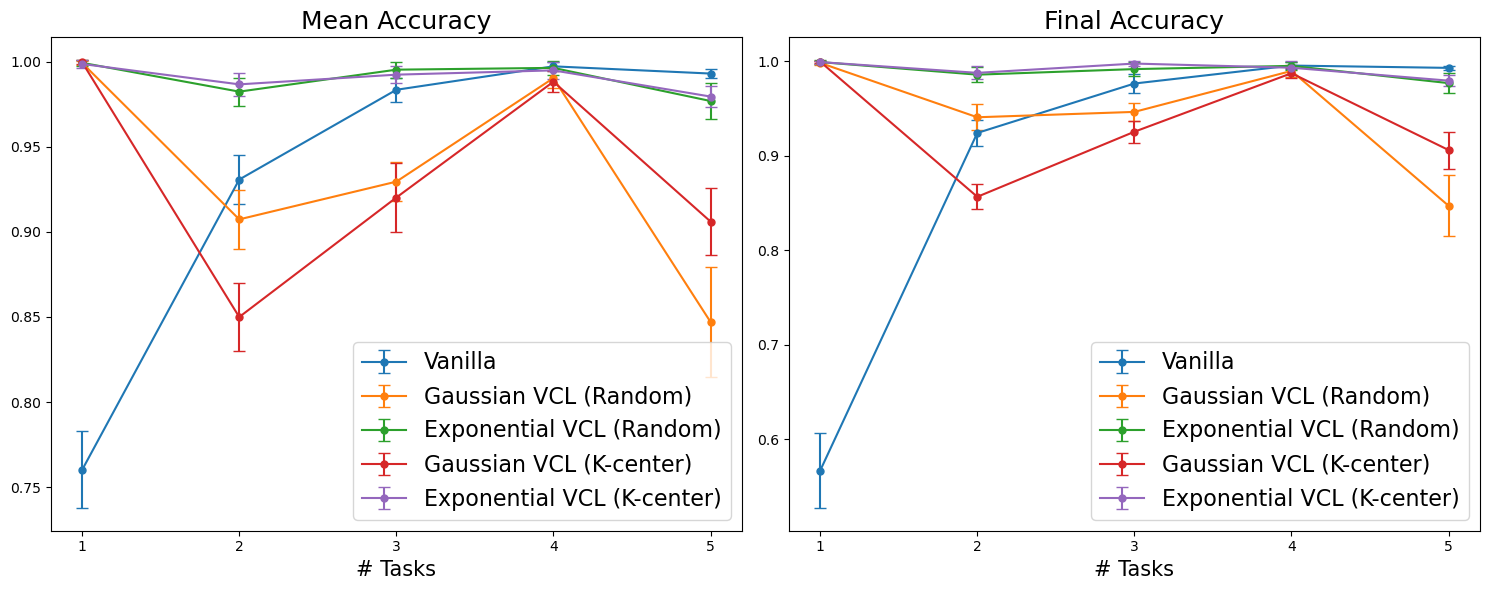

In [257]:
plot_results(ExperimentConfig(task_type='classification'), 
             cla_results, results_std=cla_std)

In [258]:
reg_results, reg_std = run_experiment(task_type='regression')


Training on Task 1 ...
... Finished training on Task 1

Task  1  RMSE: 0.0185 ± 0.0041


Training on Task 2 ...
... Finished training on Task 2

Task  1  RMSE: 0.1544 ± 0.0029
Task  2  RMSE: 0.0368 ± 0.0031


Training on Task 3 ...
... Finished training on Task 3

Task  1  RMSE: 0.2151 ± 0.0023
Task  2  RMSE: 0.1560 ± 0.0044
Task  3  RMSE: 0.0213 ± 0.0034


Training on Task 4 ...
... Finished training on Task 4

Task  1  RMSE: 0.2341 ± 0.0018
Task  2  RMSE: 0.2289 ± 0.0073
Task  3  RMSE: 0.1692 ± 0.0061
Task  4  RMSE: 0.0202 ± 0.0047


Training on Task 5 ...
... Finished training on Task 5

Task  1  RMSE: 0.2334 ± 0.0024
Task  2  RMSE: 0.2526 ± 0.0042
Task  3  RMSE: 0.1458 ± 0.0039
Task  4  RMSE: 0.0939 ± 0.0036
Task  5  RMSE: 0.0355 ± 0.0059


Training on Task 1 ...
... Finished training on Task 1

Re-training on Task 1 ...

Task  1  RMSE: 0.0785 ± 0.0021


Training on Task 2 ...
... Finished training on Task 2

Re-training on Task 1 ...

Re-training on Task 2 ...

Task  1  RMSE: 0.1

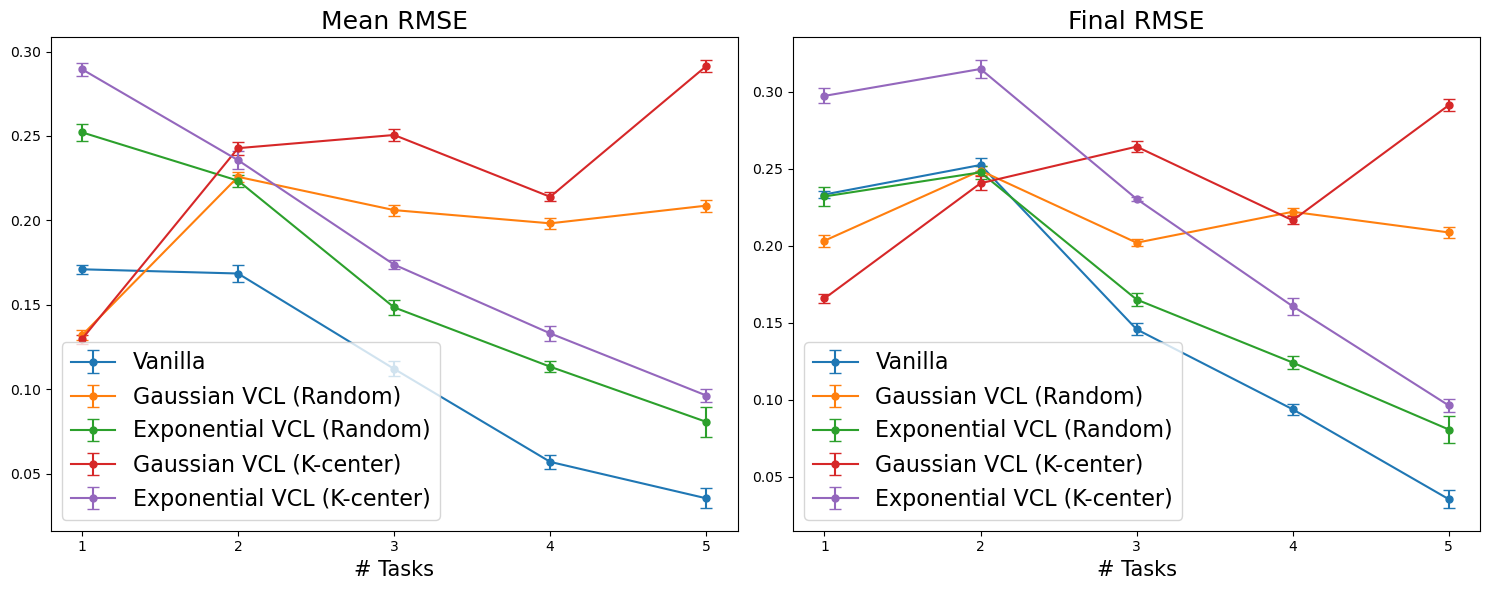

In [259]:
plot_results(ExperimentConfig(task_type='regression'), 
             reg_results, results_std=reg_std)

In [260]:
small_scale_cla_results, small_scale_cla_std = run_experiment(task_type='classification',
                                                             init_prior_scale=0.01)


Training on Task 1 ...
... Finished training on Task 1

Task  1  Accuracy: 0.9996 ± 0.0012


Training on Task 2 ...
... Finished training on Task 2

Task  1  Accuracy: 0.9983 ± 0.0019
Task  2  Accuracy: 0.9941 ± 0.0020


Training on Task 3 ...
... Finished training on Task 3

Task  1  Accuracy: 0.9710 ± 0.0084
Task  2  Accuracy: 0.9216 ± 0.0183
Task  3  Accuracy: 0.9985 ± 0.0019


Training on Task 4 ...
... Finished training on Task 4

Task  1  Accuracy: 0.7584 ± 0.0343
Task  2  Accuracy: 0.9129 ± 0.0174
Task  3  Accuracy: 0.9803 ± 0.0088
Task  4  Accuracy: 0.9989 ± 0.0020


Training on Task 5 ...
... Finished training on Task 5

Task  1  Accuracy: 0.7237 ± 0.0143
Task  2  Accuracy: 0.8951 ± 0.0191
Task  3  Accuracy: 0.8793 ± 0.0255
Task  4  Accuracy: 0.9711 ± 0.0102
Task  5  Accuracy: 0.9912 ± 0.0070


Training on Task 1 ...
... Finished training on Task 1

Re-training on Task 1 ...

Task  1  Accuracy: 0.9970 ± 0.0040


Training on Task 2 ...
... Finished training on Task 2

Re-train

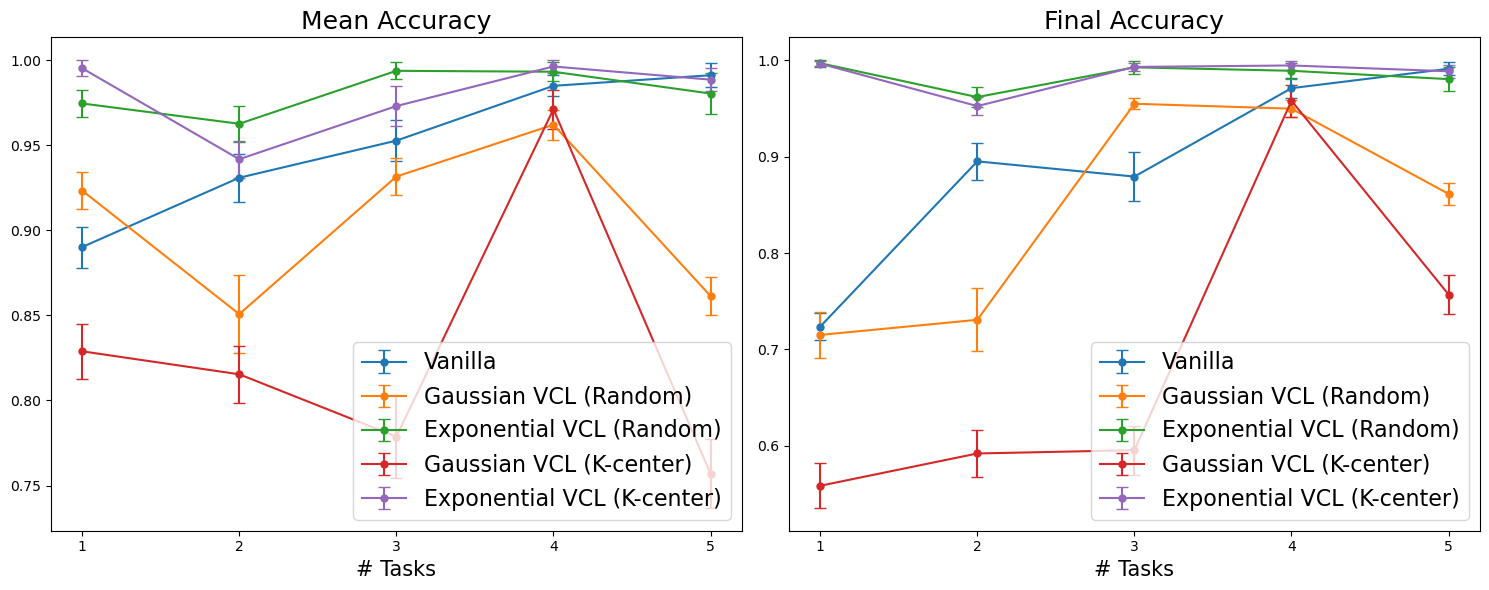

In [261]:
plot_results(ExperimentConfig(task_type='classification', init_prior_scale=0.01), 
             small_scale_cla_results, results_std=small_scale_cla_std)

In [262]:
small_scale_reg_results, small_scale_reg_std = run_experiment(task_type='regression',
                                                             init_prior_scale=0.01)


Training on Task 1 ...
... Finished training on Task 1

Task  1  RMSE: 0.0176 ± 0.0031


Training on Task 2 ...
... Finished training on Task 2

Task  1  RMSE: 0.1147 ± 0.0034
Task  2  RMSE: 0.0362 ± 0.0069


Training on Task 3 ...
... Finished training on Task 3

Task  1  RMSE: 0.1624 ± 0.0043
Task  2  RMSE: 0.1659 ± 0.0061
Task  3  RMSE: 0.0210 ± 0.0028


Training on Task 4 ...
... Finished training on Task 4

Task  1  RMSE: 0.1706 ± 0.0015
Task  2  RMSE: 0.1788 ± 0.0017
Task  3  RMSE: 0.1208 ± 0.0054
Task  4  RMSE: 0.0180 ± 0.0031


Training on Task 5 ...
... Finished training on Task 5

Task  1  RMSE: 0.1873 ± 0.0025
Task  2  RMSE: 0.2428 ± 0.0029
Task  3  RMSE: 0.1647 ± 0.0066
Task  4  RMSE: 0.1117 ± 0.0031
Task  5  RMSE: 0.0342 ± 0.0031


Training on Task 1 ...
... Finished training on Task 1

Re-training on Task 1 ...

Task  1  RMSE: 0.0654 ± 0.0037


Training on Task 2 ...
... Finished training on Task 2

Re-training on Task 1 ...

Re-training on Task 2 ...

Task  1  RMSE: 0.0

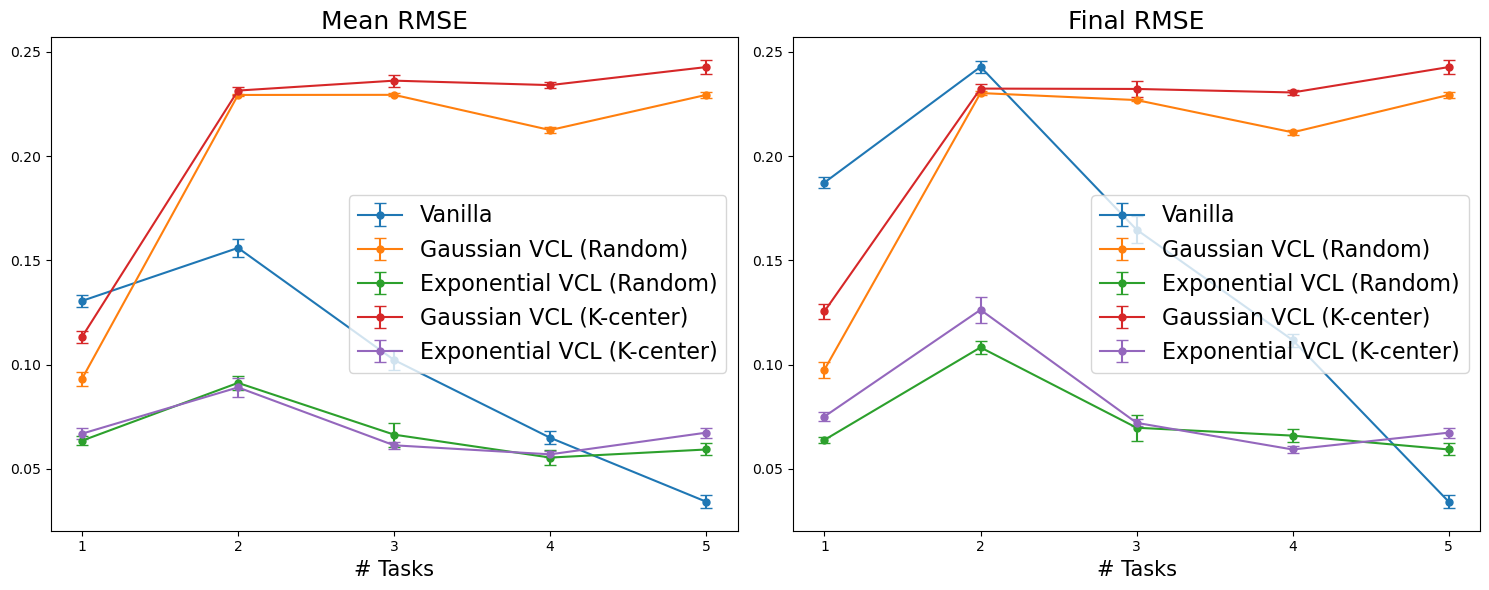

In [263]:
plot_results(ExperimentConfig(task_type='regression', init_prior_scale=0.01), 
             small_scale_reg_results, results_std=small_scale_reg_std)

In [266]:
small_coreset_cla_results, small_coreset_cla_std = run_experiment(task_type='classification',
                                                                  coreset_size=100)


Training on Task 1 ...
... Finished training on Task 1

Task  1  Accuracy: 0.9996 ± 0.0012


Training on Task 2 ...
... Finished training on Task 2

Task  1  Accuracy: 0.9987 ± 0.0018
Task  2  Accuracy: 0.9956 ± 0.0030


Training on Task 3 ...
... Finished training on Task 3

Task  1  Accuracy: 0.8519 ± 0.0292
Task  2  Accuracy: 0.6088 ± 0.0148
Task  3  Accuracy: 0.9980 ± 0.0028


Training on Task 4 ...
... Finished training on Task 4

Task  1  Accuracy: 0.5996 ± 0.0179
Task  2  Accuracy: 0.7219 ± 0.0322
Task  3  Accuracy: 0.9868 ± 0.0099
Task  4  Accuracy: 0.9994 ± 0.0017


Training on Task 5 ...
... Finished training on Task 5

Task  1  Accuracy: 0.5838 ± 0.0363
Task  2  Accuracy: 0.5985 ± 0.0247
Task  3  Accuracy: 0.9848 ± 0.0045
Task  4  Accuracy: 0.9906 ± 0.0054
Task  5  Accuracy: 0.9909 ± 0.0043


Training on Task 1 ...
... Finished training on Task 1

Re-training on Task 1 ...

Task  1  Accuracy: 0.9991 ± 0.0025


Training on Task 2 ...
... Finished training on Task 2

Re-train

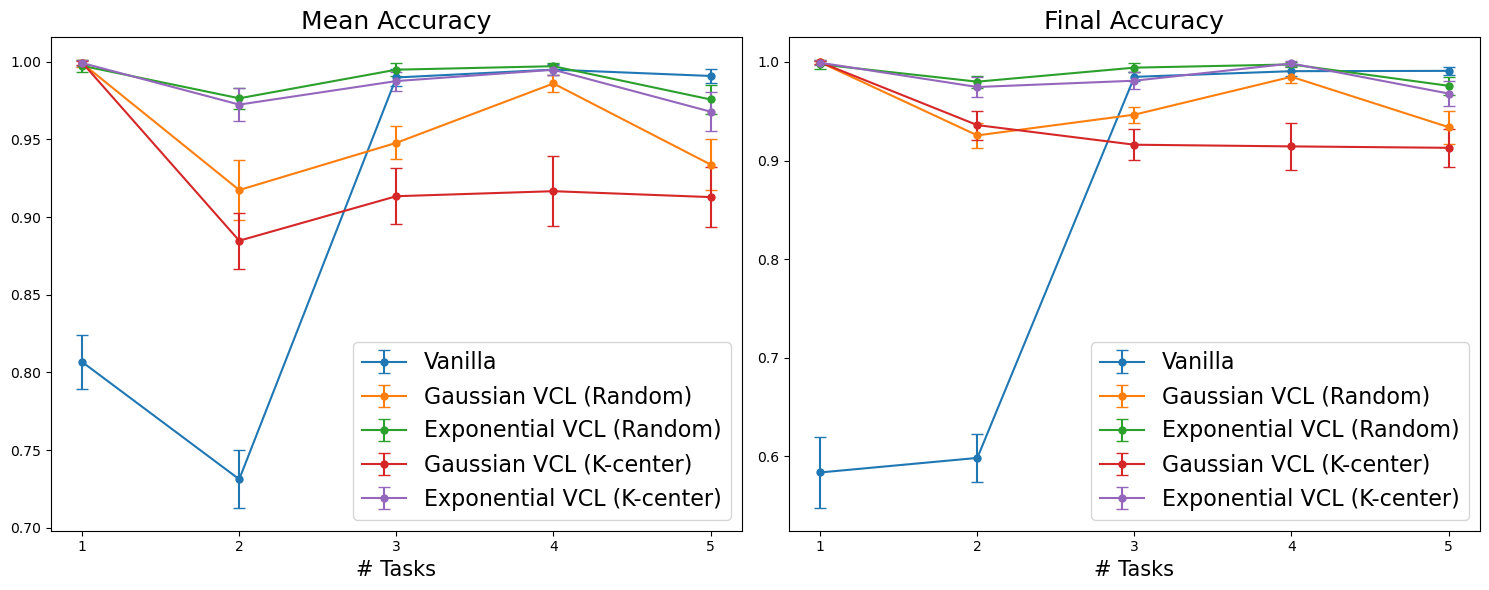

In [267]:
plot_results(ExperimentConfig(task_type='classification', coreset_size=100), 
             small_coreset_cla_results, results_std=small_coreset_cla_std)

In [268]:
small_coreset_reg_results, small_coreset_reg_std = run_experiment(task_type='regression',
                                                                coreset_size=100)


Training on Task 1 ...
... Finished training on Task 1

Task  1  RMSE: 0.0174 ± 0.0042


Training on Task 2 ...
... Finished training on Task 2

Task  1  RMSE: 0.1288 ± 0.0019
Task  2  RMSE: 0.0351 ± 0.0043


Training on Task 3 ...
... Finished training on Task 3

Task  1  RMSE: 0.2161 ± 0.0020
Task  2  RMSE: 0.1568 ± 0.0058
Task  3  RMSE: 0.0230 ± 0.0029


Training on Task 4 ...
... Finished training on Task 4

Task  1  RMSE: 0.2170 ± 0.0019
Task  2  RMSE: 0.1957 ± 0.0043
Task  3  RMSE: 0.1386 ± 0.0033
Task  4  RMSE: 0.0198 ± 0.0056


Training on Task 5 ...
... Finished training on Task 5

Task  1  RMSE: 0.2217 ± 0.0031
Task  2  RMSE: 0.1764 ± 0.0018
Task  3  RMSE: 0.1452 ± 0.0038
Task  4  RMSE: 0.0929 ± 0.0022
Task  5  RMSE: 0.0364 ± 0.0069


Training on Task 1 ...
... Finished training on Task 1

Re-training on Task 1 ...

Task  1  RMSE: 0.0738 ± 0.0020


Training on Task 2 ...
... Finished training on Task 2

Re-training on Task 1 ...

Re-training on Task 2 ...

Task  1  RMSE: 0.0

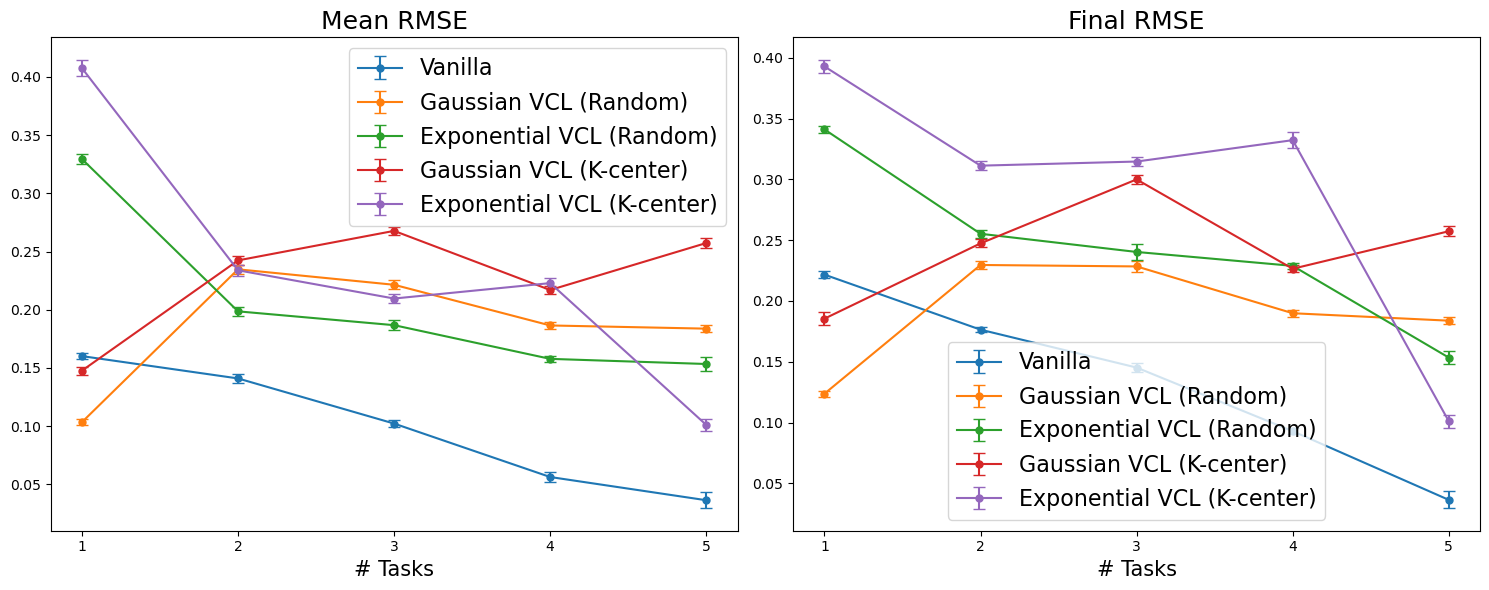

In [269]:
plot_results(ExperimentConfig(task_type='regression', coreset_size=100), 
             small_coreset_reg_results, results_std=small_coreset_reg_std)